## Tesla and Gasoline
By John Loeber

Notebook released under the Creative Commons Attribution 4.0 License.

---

### Introduction

Is the stock price of Tesla Motors (TSLA) linked to the price of gasoline? 

Some people think that cheap gasoline incentivizes the purchase of gas-fuelled cars, lowering demand for Teslas, thus causing a drop in TSLA stock price. I try to find out whether that is true: I investigate the relationship between the price of TSLA and the price of UGA, an ETF tracking the price of gasoline.


### Conclusion

The price of <strong>TSLA roughly follows the price of gasoline, with a lag of about 50 business days.</strong> However, statistical correlations show only very weak results, which is likely due to two reasons:
1. The price of TSLA is not only impacted by gas -- there are other factors: earnings reports, rumours, etc. They cause occasional (smaller) movements in TSLA that are not related to the price of gas.
2. The lag is not necessarily constant --  there's no reason why the offset should always be 50 business days. Sometimes TSLA may take longer to respond, and at other times it may respond more quickly. This makes it hard to fit the time-series to each other in a way that yields a strong correlation.


### Going Further

Use the result, that TSLA roughly follows the price of gasoline with a lag of about 50 business days, to construct a trading strategy. It will be worthwhile to [write an algorithm](https://www.quantopian.com/algorithms) to attempt to trade on this pattern.

To expand further upon this project:
 - Test against crude oil and energy ETFs to search for other signals in the data.
 - Query the [Quantopian Fundamentals](https://www.quantopian.com/help/fundamentals) and use quarterly sales/revenue data to see how these details correspond to the price of gasoline. 
 - Consider commodity prices from NYMEX or other potentially more informative datasets.
 
Have questions? Post to the [community](https://www.quantopian.com/posts) or send us an email: feedback@quantopian.com. 

## Investigation

I'll use [Kalman filters](https://www.quantopian.com/posts/quantopian-lecture-series-kalman-filters) to obtain moving averages, both of TSLA and of the ETFs. I overlay these moving average plots and look for relationships between the two (using both the obtained moving averages and the raw data).

In [2]:
# Import libraries
from matplotlib import pyplot
from pykalman import KalmanFilter
import numpy
import scipy
import time
import datetime

In [3]:
# Initialize a Kalman Filter.
# Using kf to filter does not change the values of kf, so we don't need to ever reinitialize it.
kf = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 1,
                  observation_covariance=1,
                  transition_covariance=.01)

In [4]:
# helper functions
# for converting dates to a plottable form
def convert_date(mydate):
    # return time.mktime(datetime.datetime.strptime(mydate, "%Y-%m-%d").timetuple())
    return datetime.datetime.strptime(mydate, "%Y-%m-%d")
    
# for grabbing dates and prices for a relevant equity
def get_data(equity_name,trading_start,trading_end='2015-07-20'):
    # using today as a default arg.
    stock_data = get_pricing(equity_name,
                        start_date = trading_start,
                        end_date = trading_end,
                        fields = ['close_price'],
                        frequency = 'daily')
    stock_data['date'] = stock_data.index
    # drop nans. For whatever reason, nans were causing the kf to return a nan array.
    stock_data = stock_data.dropna()
    # the dates are just those on which the prices were recorded
    dates = stock_data['date']
    dates = [convert_date(str(x)[:10]) for x in dates]
    prices = stock_data['close_price']
    return dates, prices

In [5]:
# TSLA started trading on Jun-29-2010.
dates_tsla, scores_tsla = get_data('TSLA','2010-06-29')
# Apply Kalman filter to get a rolling average
scores_tsla_means, _ = kf.filter(scores_tsla.values)

I'll plot the daily TSLA price and its Kalman-filtered moving average on it, simply to get a feel for the data.

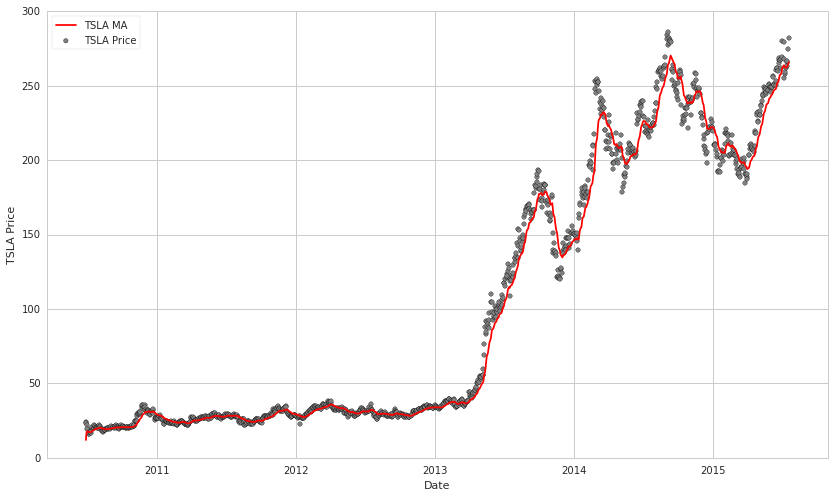

In [6]:
# Use a scatterplot instead of a line plot because a line plot would be far too noisy.
pyplot.scatter(dates_tsla,scores_tsla,c='gray',label='TSLA Price')
pyplot.plot(dates_tsla,scores_tsla_means, c='red', label='TSLA MA')
pyplot.ylabel('TSLA Price')
pyplot.xlabel('Date')
pyplot.ylim([0,300])
pyplot.legend(loc=2)
pyplot.show()

This plot raises an important consideration: in 2012, Tesla debuted the Model S and delivered 2650 vehicles. It was only midway through 2013 that Tesla rose to prominence, having dramatically increased their production output. Thus, the period between 2010 and mid-2013 is likely misleading/irrelevant. In this investigation, I will concentrate on data from June 2013 onwards.

### UGA

UGA is the ETF tracking the price of gasoline.

In [7]:
# Get UGA data and apply the Kalman filter to get a moving average.
dates_uga, scores_uga = get_data('UGA','2013-06-01')
scores_uga_means, _ = kf.filter(scores_uga.values)

# Get TSLA for June 2013 onwards, and apply the Kalman Filter.
dates_tsla2, scores_tsla2 = get_data('TSLA','2013-06-01')
scores_tsla_means2, _ = kf.filter(scores_tsla2.values)

We'll now plot the TSLA price (moving average) and the UGA price (moving average).

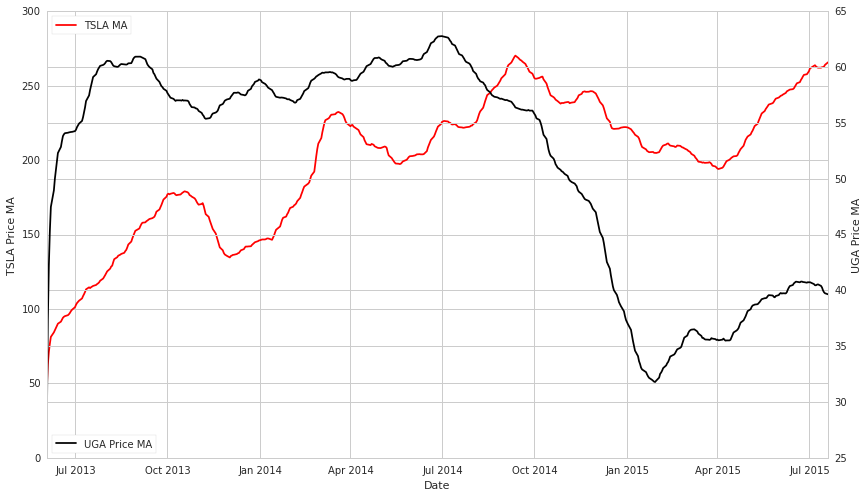

In [8]:
_, ax1 = pyplot.subplots()
ax1.plot(dates_tsla2,scores_tsla_means2, c='red', label='TSLA MA')
pyplot.xlabel('Date')
pyplot.ylabel('TSLA Price MA')
pyplot.legend(loc=2)
# twinx allows us to use the same plot
ax2 = ax1.twinx()
ax2.plot(dates_uga, scores_uga_means, c='black', label='UGA Price MA')
pyplot.ylabel('UGA Price MA')
pyplot.legend(loc=3)
pyplot.show()

You can immediately see a strong, though perhaps lagged correspondence. If you line up the most prominent peaks and troughs in prices, you can see that the two time-series appear to correlate strongly, albeit with a lag of what looks like about two or three months. We'll use a function to find the lag that maximizes correlation.

In [9]:
def find_offset(ts1,ts2,window):
    """ Finds the offset between two equal-length timeseries that maximizies correlation. 
        Window is # of days by which we want to left- or right-shift.
        N.B. You'll have to adjust the function for negative correlations."""
    l = len(ts1)
    if l!=len(ts2):
        raise Exception("Error! Timeseries lengths not equal!")
    max_i_spearman = -1000
    max_spearman = -1000
    spear_offsets = []
    
    # we try all possible offsets from -window to +window.
    # we record the spearman correlation for each offset.
    for i in range(window,0,-1):
        series1 = ts1[i:]
        series2 = ts2[:l-i]
        # spearmanr is a correlation test
        spear = scipy.stats.spearmanr(series1,series2)[0]
        spear_offsets.append(spear)
        
        if spear > max_spearman:
            # update best correlation
            max_spearman = spear
            max_i_spearman = -i

    for i in range(0,window):
        series1 = ts1[:l-i]
        series2 = ts2[i:]
        spear = scipy.stats.spearmanr(series1,series2)[0]
        spear_offsets.append(spear)
        if spear > max_spearman:
            max_spearman = spear
            max_i_spearman = i

    print "Max Spearman:", max_spearman, " At offset: ", max_i_spearman
    pyplot.plot(range(-window,window),spear_offsets, c='green', label='Spearman Correlation')
    pyplot.xlabel('Offset Size (Number of Business Days)')
    pyplot.ylabel('Spearman Correlation')
    pyplot.legend(loc=3)
    pyplot.show()

Kalman-Filtered Smoothed Data
Max Spearman: 0.122765668022  At offset:  -126


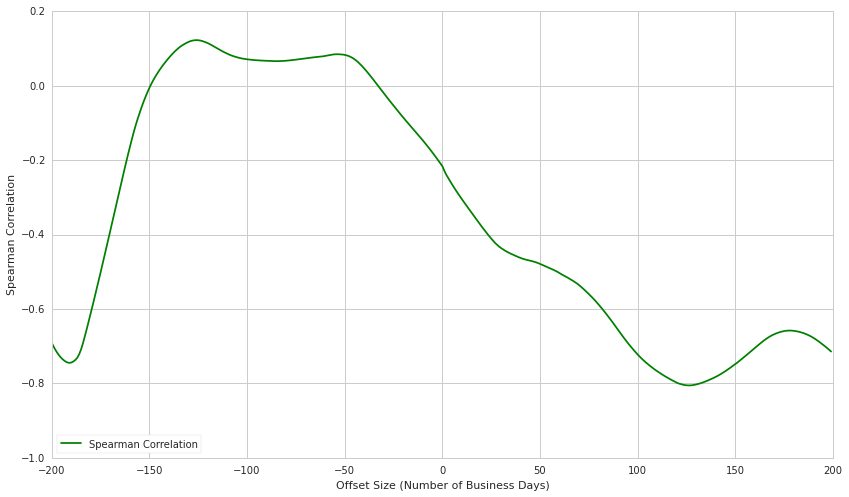

Raw Data
Max Spearman: -0.0133470797619  At offset:  -50


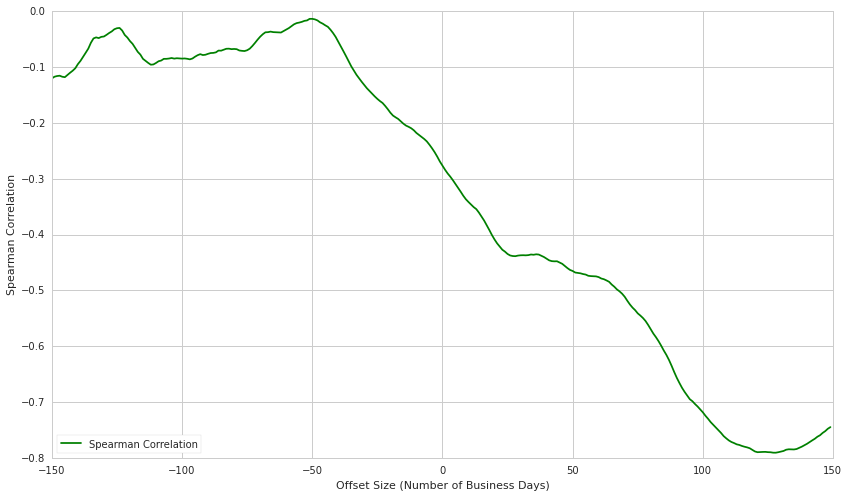

In [10]:
print "Kalman-Filtered Smoothed Data"
find_offset(scores_tsla_means2,scores_uga_means,200)
print "Raw Data"
find_offset(scores_tsla2,scores_uga,150)

These plots are not promising at all! I want to find a strong positive correlation between TSLA and UGA, but neither in the smoothed nor in the raw data is there a strong, positive correlation. However, I did find that negative offsets of 126 and 50 days are correlation-maximizing, so we'll take a look at the smoothed data with these offsets.

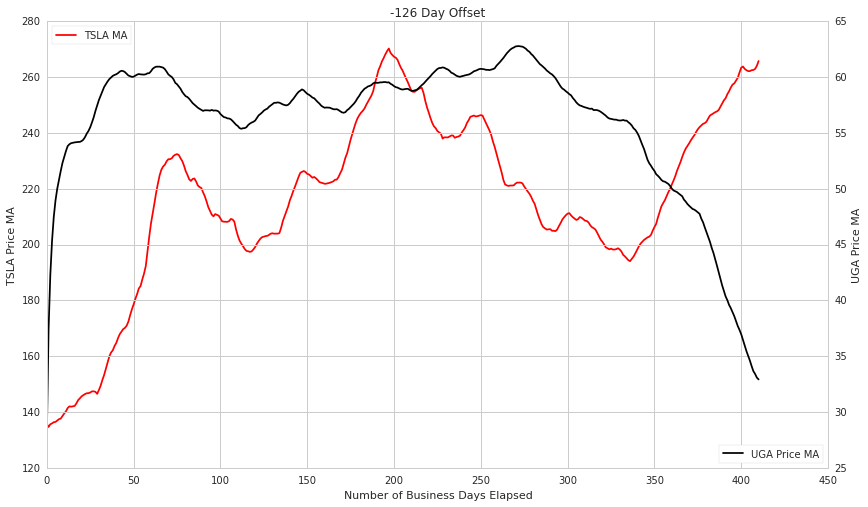

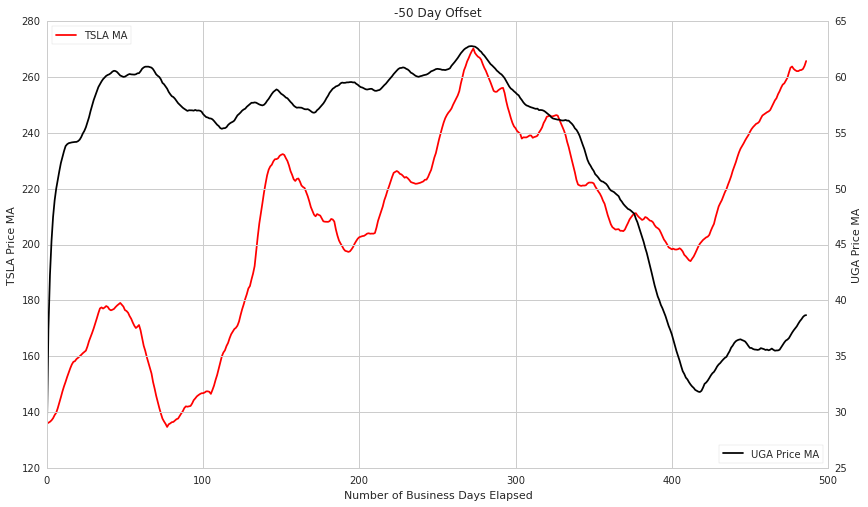

In [11]:
# plotting formalities for 126-day offset

d = 126
cseries1 = scores_tsla_means2[d:]
cseries2 = scores_uga_means[:len(scores_tsla_means2)-d]
r = range(len(cseries1))

_, ax1 = pyplot.subplots()
ax1.plot(r, cseries1, c='red', label='TSLA MA')
pyplot.xlabel('Number of Business Days Elapsed')
pyplot.ylabel('TSLA Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(r, cseries2, c='black', label='UGA Price MA')
pyplot.ylabel('UGA Price MA')
pyplot.legend(loc=4)
pyplot.title("-126 Day Offset")
pyplot.show()

# plotting for 50-day offset

d = 50
cseries1 = scores_tsla_means2[d:]
cseries2 = scores_uga_means[:len(scores_tsla_means2)-d]
r = range(len(cseries1))

_, ax1 = pyplot.subplots()
ax1.plot(r, cseries1, c='red', label='TSLA MA')
pyplot.xlabel('Number of Business Days Elapsed')
pyplot.ylabel('TSLA Price MA')
pyplot.legend(loc=2)
ax2 = ax1.twinx()
ax2.plot(r, cseries2, c='black', label='UGA Price MA')
pyplot.ylabel('UGA Price MA')
pyplot.legend(loc=4)
pyplot.title("-50 Day Offset")
pyplot.show()

It is my opinion that the 50-day offset is a better fit. Not only do the 50-day plots visually appear to correspond more strongly (we can line up all major movements), it is also more plausible that gas price leads Tesla by 50 business days, rather than by 120 business days. However, looking at the 50-day plot, it is nonetheless surprising that the Spearman correlation is so low:

In [15]:
print scipy.stats.spearmanr(scores_tsla_means2[d:][250:],scores_uga_means[:len(scores_tsla_means2)-d][250:])

(0.54744356442426789, 6.2332048775765889e-20)


A correlation of 0.08 is statistically extremely weak -- basically signifying no relationship. To me, the visual relationship looks stronger than that. I guessed that there could be some noise obscuring the correlation, so I applied a second round of Kalman filters to both datasets. Doing this, I was able to drive the maximum correlation up to 0.20, but that's still not as strong as we would want.

I think the issue is twofold:
1. The <strong>price of TSLA is not only impacted by gas</strong> -- there are obviously other factors, like earnings reports, rumours, etc. This causes occasional movements in price that are not related to the price of gas.
2. The <strong>offset is not necessarily constant</strong> -- in the plot above, you can see that some movements seem not to line up entirely (which, of course, has disastrous consequences for the numerical correlation), and that's to be expected: there's no reason why the offset should always be 50 business days -- sometimes TSLA may take longer to respond, and at other times it may respond more quickly.

In any case, I consider the above plot quite compelling -- I will devote a future investigation to attempting to trade on the lag between TSLA and UGA. I invite you to do the same.